## Praca domowa 6
Piotr Marciniak

### Załadowanie zbioru danych i przedstawienie obrazków

In [1]:
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import seaborn_image as isns
import numpy as np

data = fetch_olivetti_faces()
images = data.get('images')
images.shape

(400, 64, 64)

In [2]:
images

array([[[0.30991736, 0.3677686 , 0.41735536, ..., 0.37190083,
         0.3305785 , 0.30578512],
        [0.3429752 , 0.40495867, 0.43801653, ..., 0.37190083,
         0.338843  , 0.3140496 ],
        [0.3429752 , 0.41735536, 0.45041323, ..., 0.38016528,
         0.338843  , 0.29752067],
        ...,
        [0.21487603, 0.20661157, 0.2231405 , ..., 0.15289256,
         0.16528925, 0.17355372],
        [0.20247933, 0.2107438 , 0.2107438 , ..., 0.14876033,
         0.16115703, 0.16528925],
        [0.20247933, 0.20661157, 0.20247933, ..., 0.15289256,
         0.16115703, 0.1570248 ]],

       [[0.45454547, 0.47107437, 0.5123967 , ..., 0.19008264,
         0.18595041, 0.18595041],
        [0.446281  , 0.48347107, 0.5206612 , ..., 0.21487603,
         0.2107438 , 0.2107438 ],
        [0.49586776, 0.5165289 , 0.53305787, ..., 0.20247933,
         0.20661157, 0.20661157],
        ...,
        [0.77272725, 0.78099173, 0.7933884 , ..., 0.1446281 ,
         0.1446281 , 0.1446281 ],
        [0.7

Mamy $400$ zdjęć o wymiarach $64 \times 64$ w grayscale.

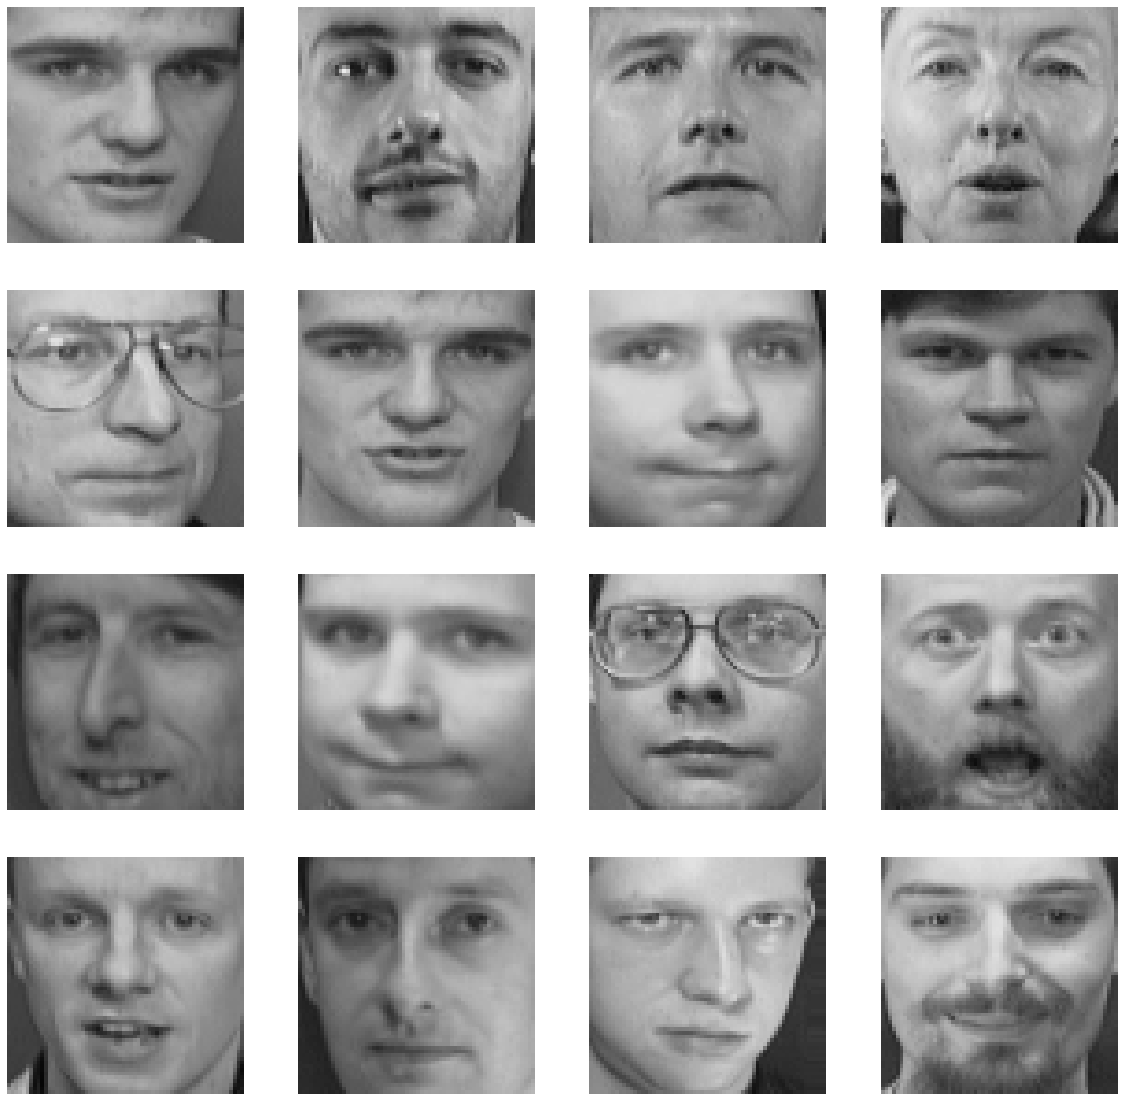

In [3]:
random = np.random.randint(0, 400, 16)

def plot_images(images, func=None):    
    plt.figure(figsize=(20, 20))
    
    for i in range(4):
        for j in range(4):
            plt.subplot(4, 4, 4*i+j+1)
            if func is None:
                plt.imshow(images[4*i+j, :, :], cmap='gray', vmin=0, vmax=1, origin='upper')
            else:
                plt.imshow(func(images[4*i+j, :, :]), cmap='gray', vmin=0, vmax=1, origin='upper')
            plt.axis('off')
            
    plt.show()
        
plot_images(images[random, :, :])

### Kompresja

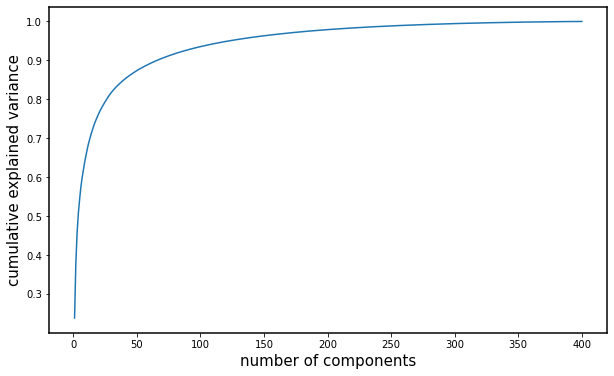

In [4]:
from sklearn.decomposition import PCA
images_raw = data.get('data')
pca = PCA().fit(images_raw)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Widzimy, że dla 144, dostajemy około $95\%$ wyjaśnionej wariancji, więc skorzystajmy z tego ustawienia.

In [5]:
np.sum(pca.explained_variance_ratio_[:144])

0.96070284

#### Skompresowane zdjęcia

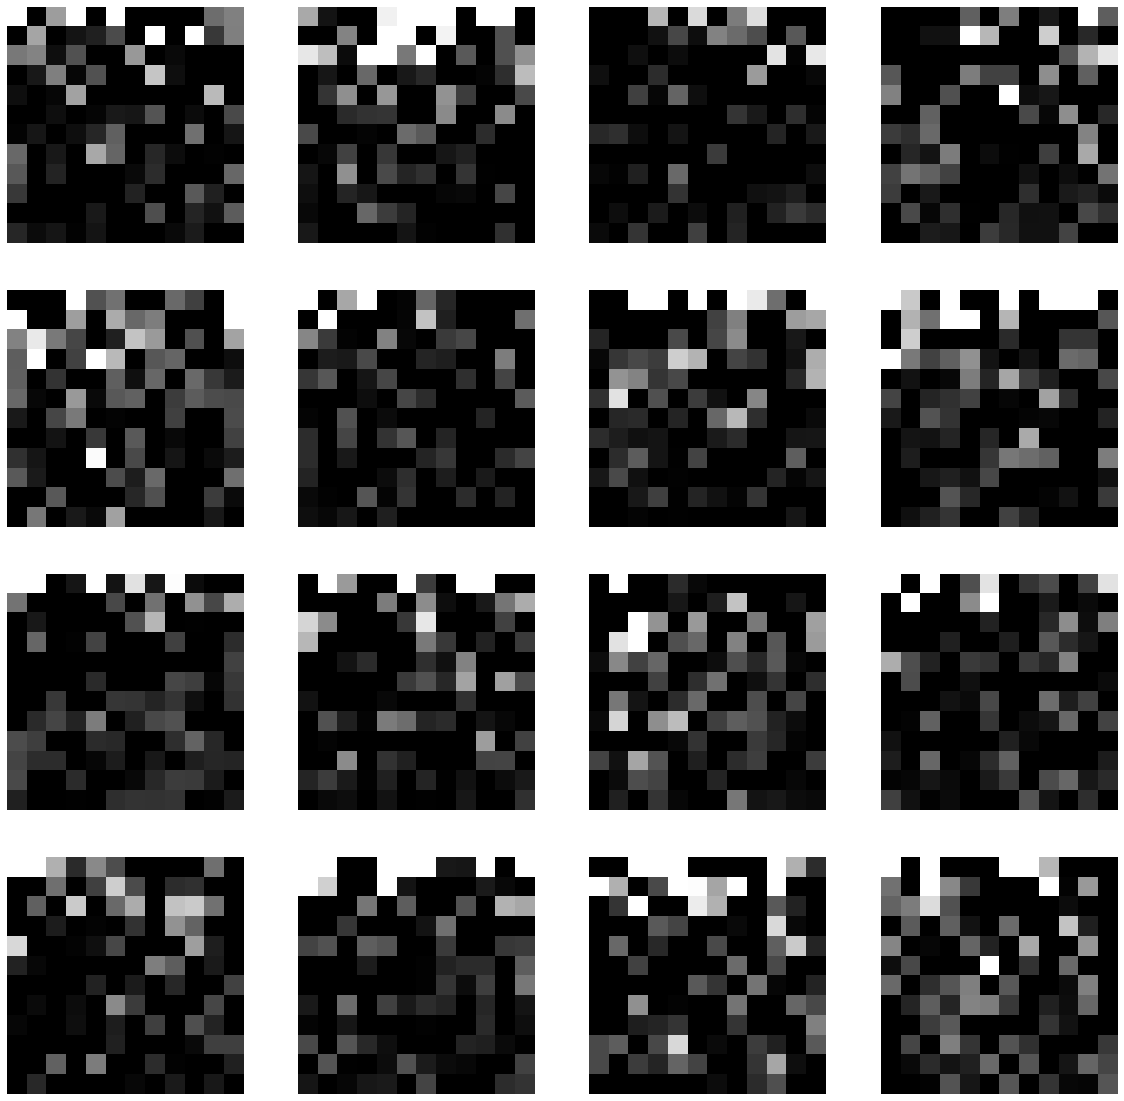

In [6]:
pca = PCA(n_components=144)
transformed_images = pca.fit_transform(images_raw).reshape(400, 12, 12)
plot_images(transformed_images[random, :, :])

Wygląda jak losowy szum, ale widzimy, że dane po skompresowaniu, nie mają sensu w charakterze wyświetlania.

#### Stopień kompresji

In [7]:
images_raw.nbytes/transformed_images.nbytes

28.444444444444443

### Transformacja odwrotna

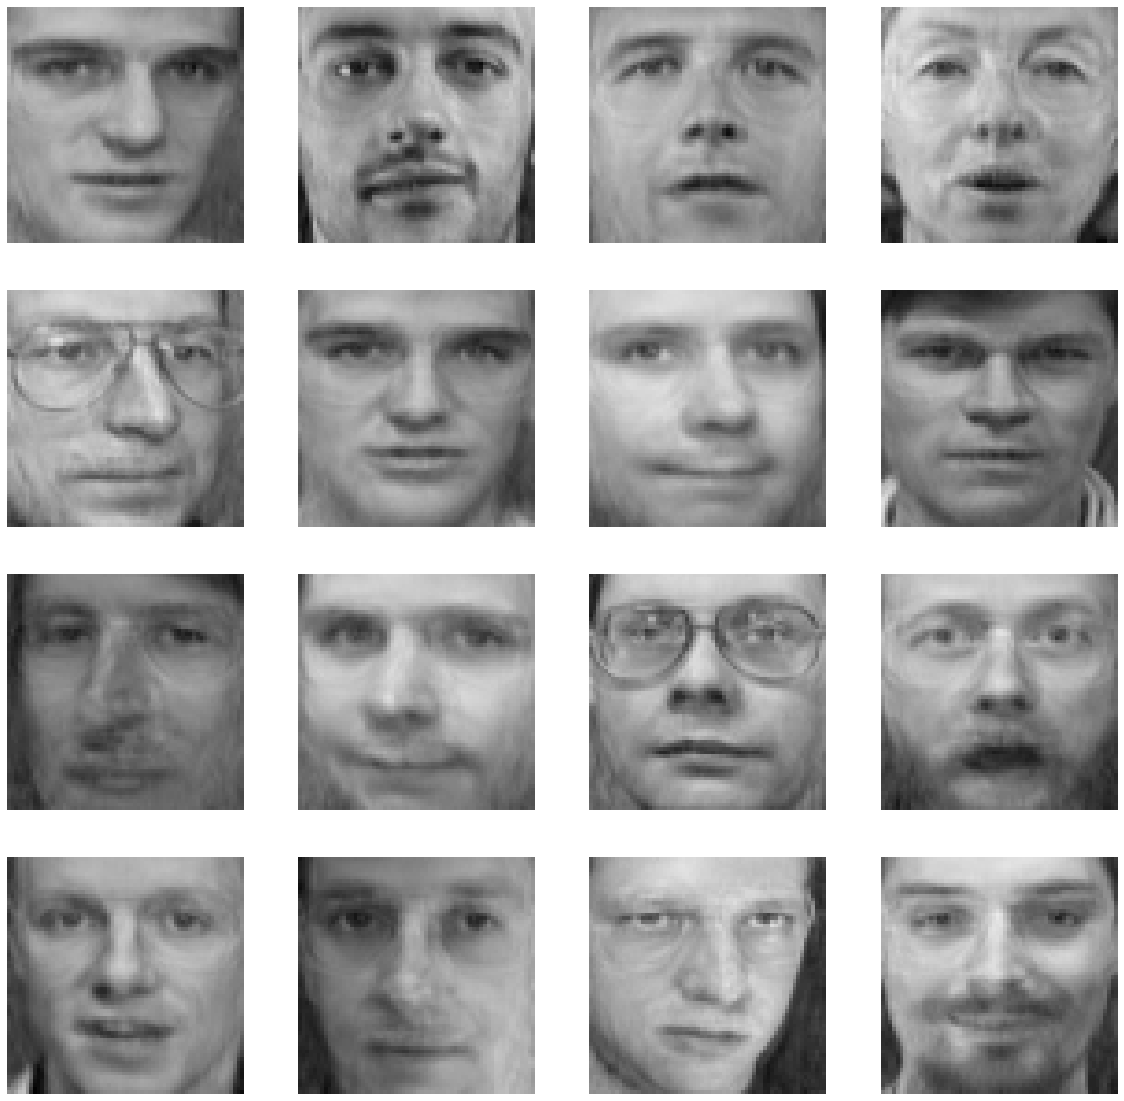

In [8]:
inv_images = pca.inverse_transform(transformed_images.reshape(400, 144))
plot_images(inv_images.reshape(400, 64, 64)[random, :, :])

#### RMSE

In [9]:
from sklearn.metrics import mean_squared_error
import pandas as pd

summary_dict = {'normal': mean_squared_error(images_raw, inv_images, squared=False)}
summary = pd.DataFrame.from_dict(summary_dict, orient='index', columns=["RMSE"])
summary

,RMSE
normal,0.026829


### Kilka modyfikacji
#### Histogram equalization
##### Wybrane zdjęcia

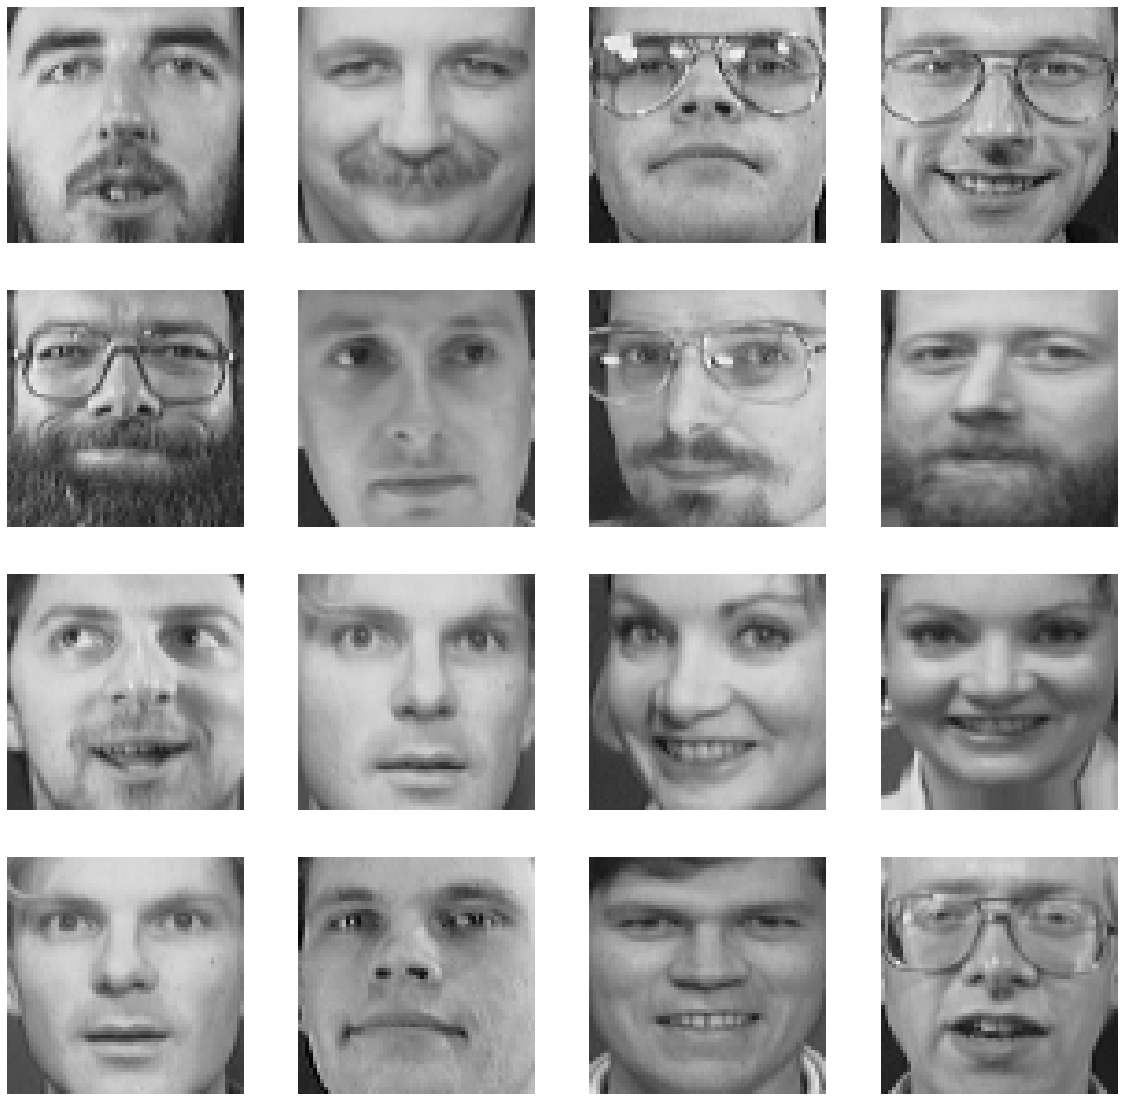

In [10]:
rand1 = np.random.randint(0, 400, 16)
plot_images(images[rand1, :, :])

##### Po transformacji

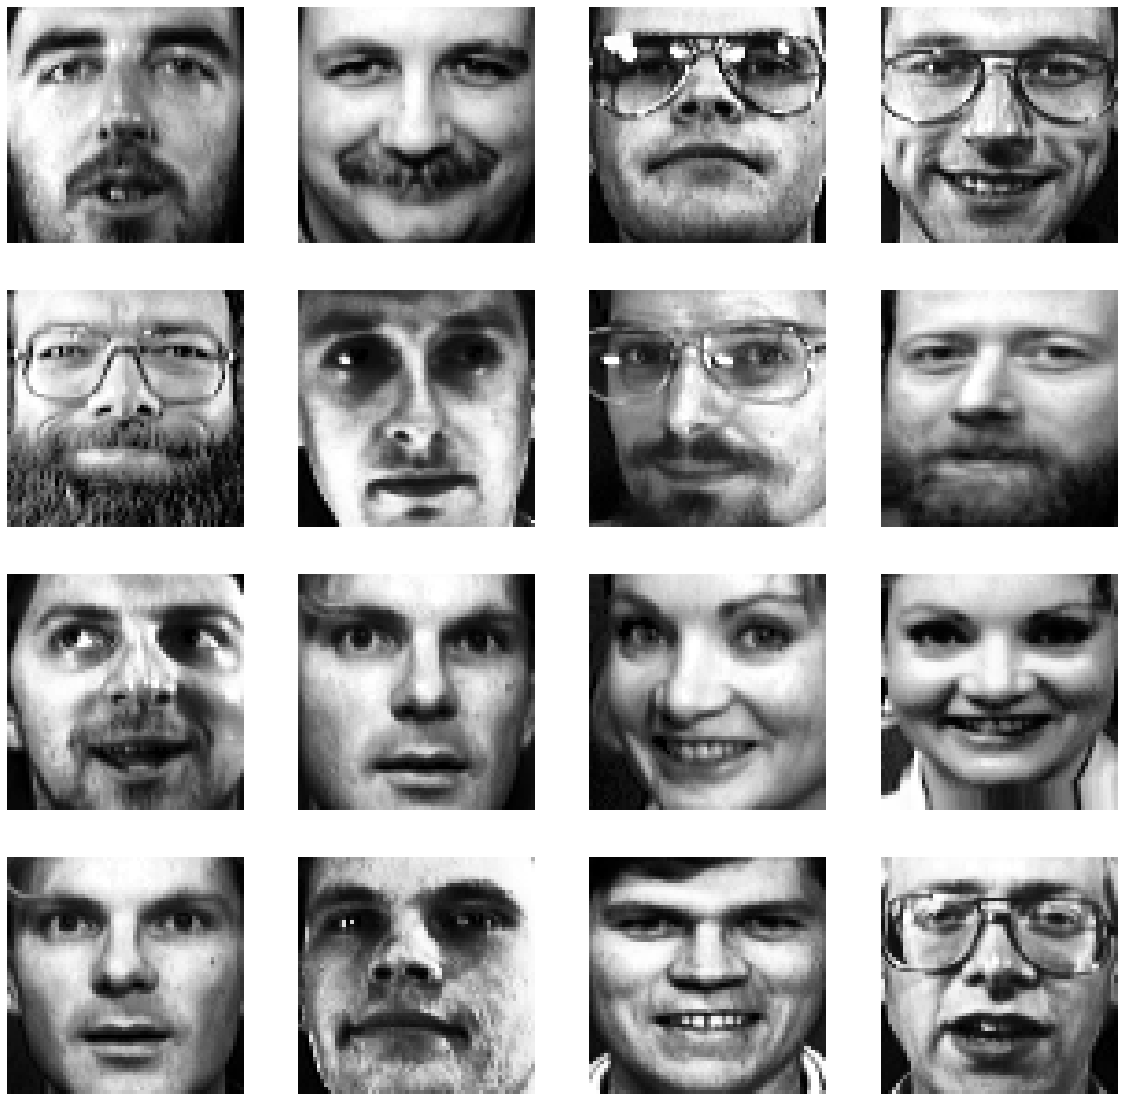

In [11]:
from skimage.exposure import equalize_hist
plot_images(images[rand1, :, :], func=equalize_hist)

In [12]:
equalize_images = equalize_hist(images)

#### Obracanie o 90 stopni

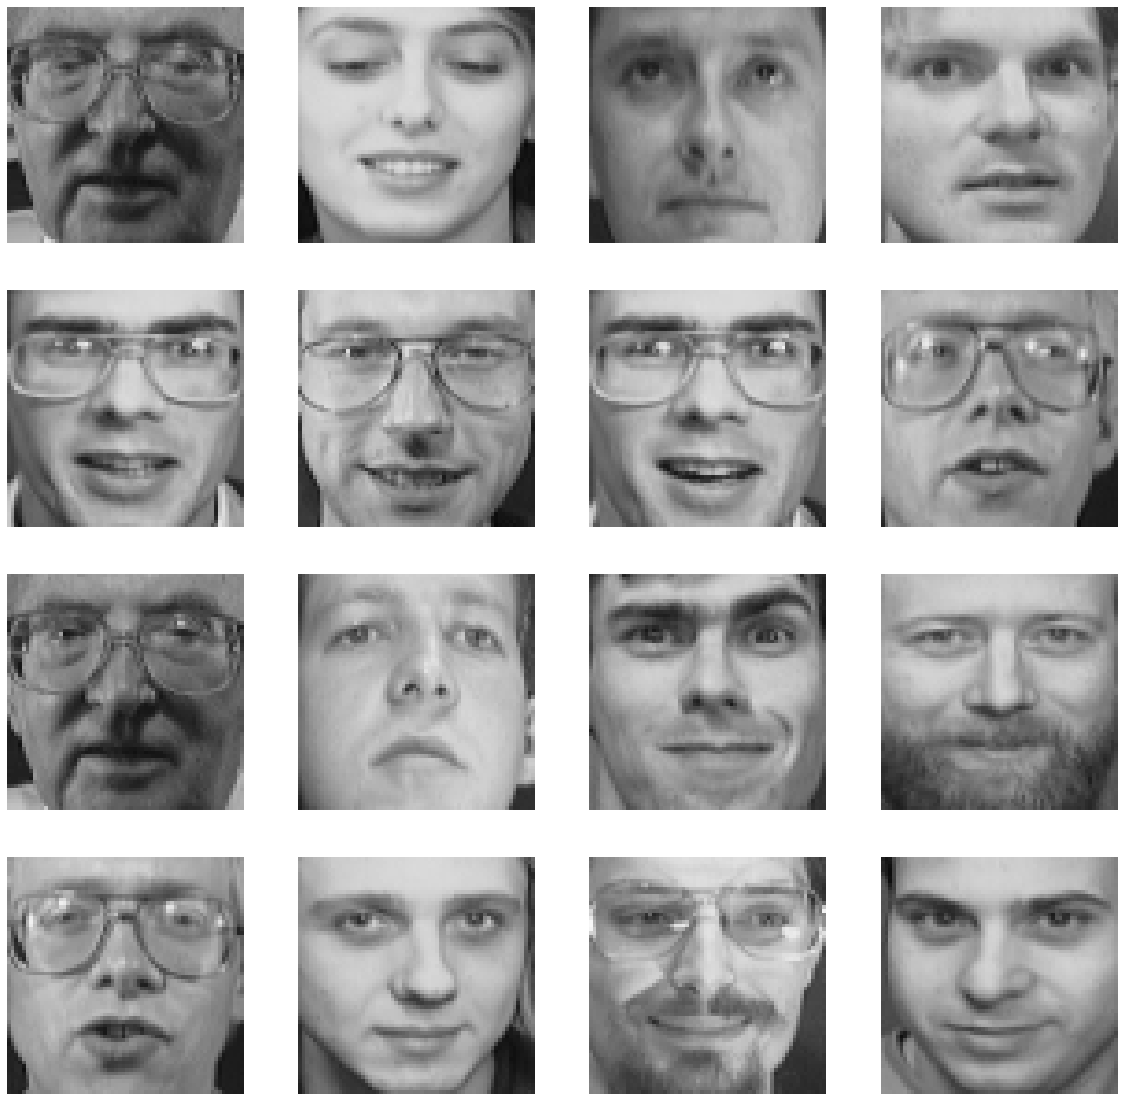

In [13]:
from skimage.transform import rotate

rand2 = np.random.randint(0, 400, 16)
plot_images(images[rand2, :, :])

##### Po transformacji

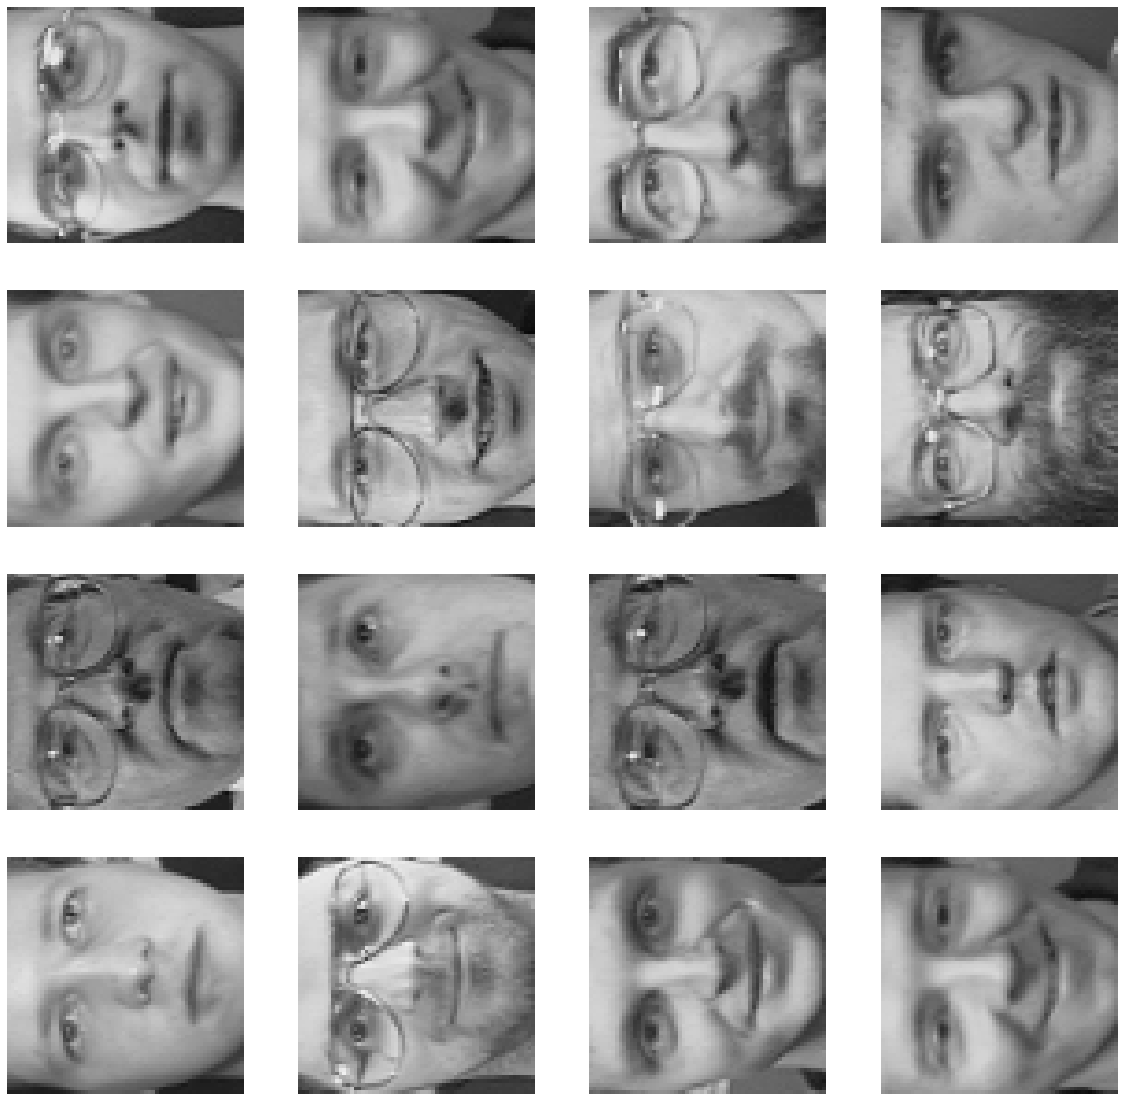

In [14]:
from functools import partial
rand2 = np.random.randint(0, 400, 16)
plot_images(images[rand2, :, :], func=partial(rotate, angle=90))

In [15]:
rotate_images = rotate(images, angle=90)

#### Odbicie do góry nogami

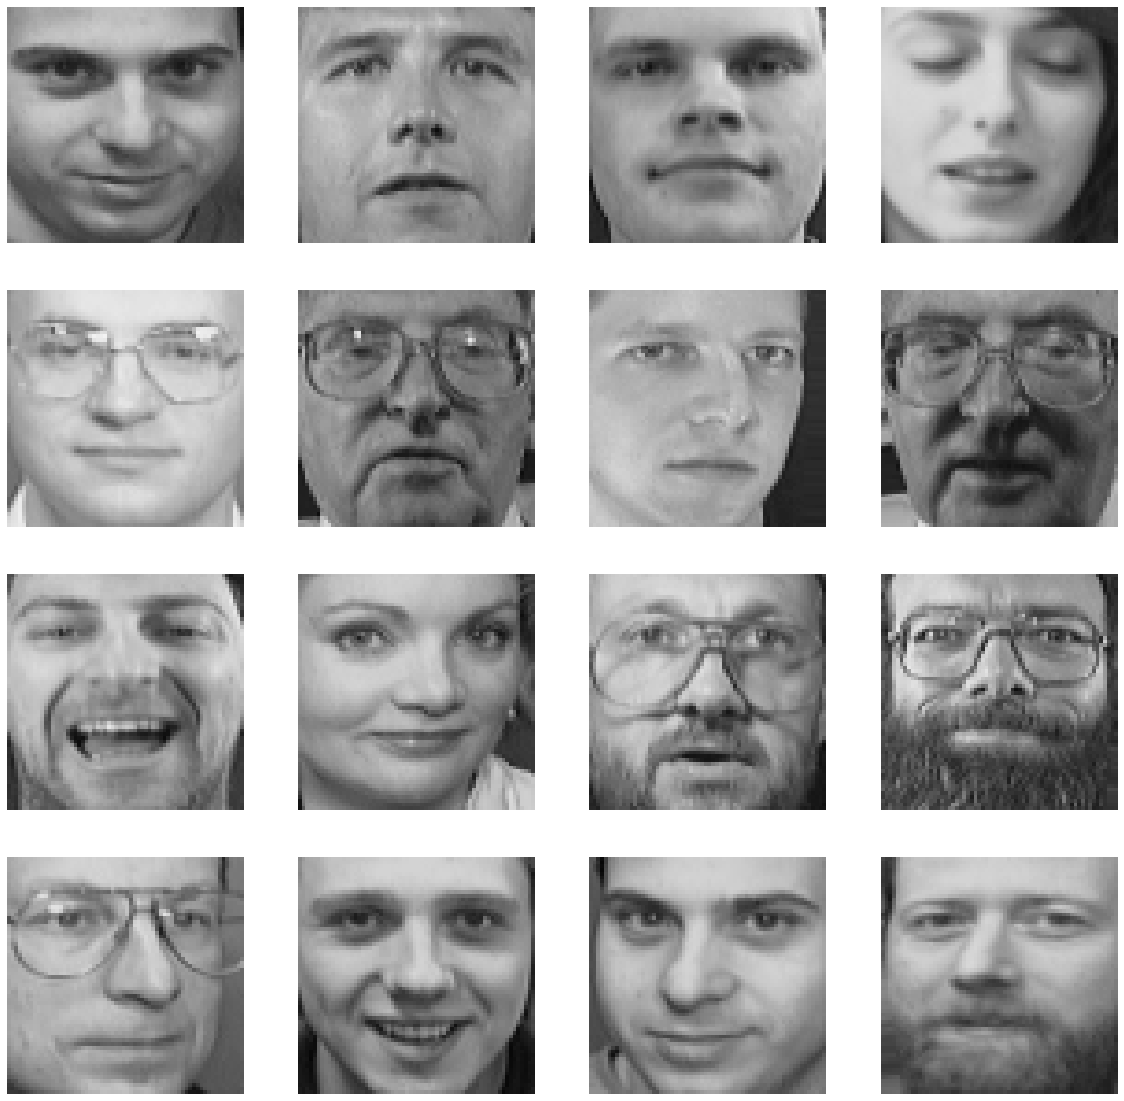

In [16]:
from numpy import fliplr
rand3 = np.random.randint(0, 400, 16)
plot_images(images[rand3, :, :])

##### Po transformacji

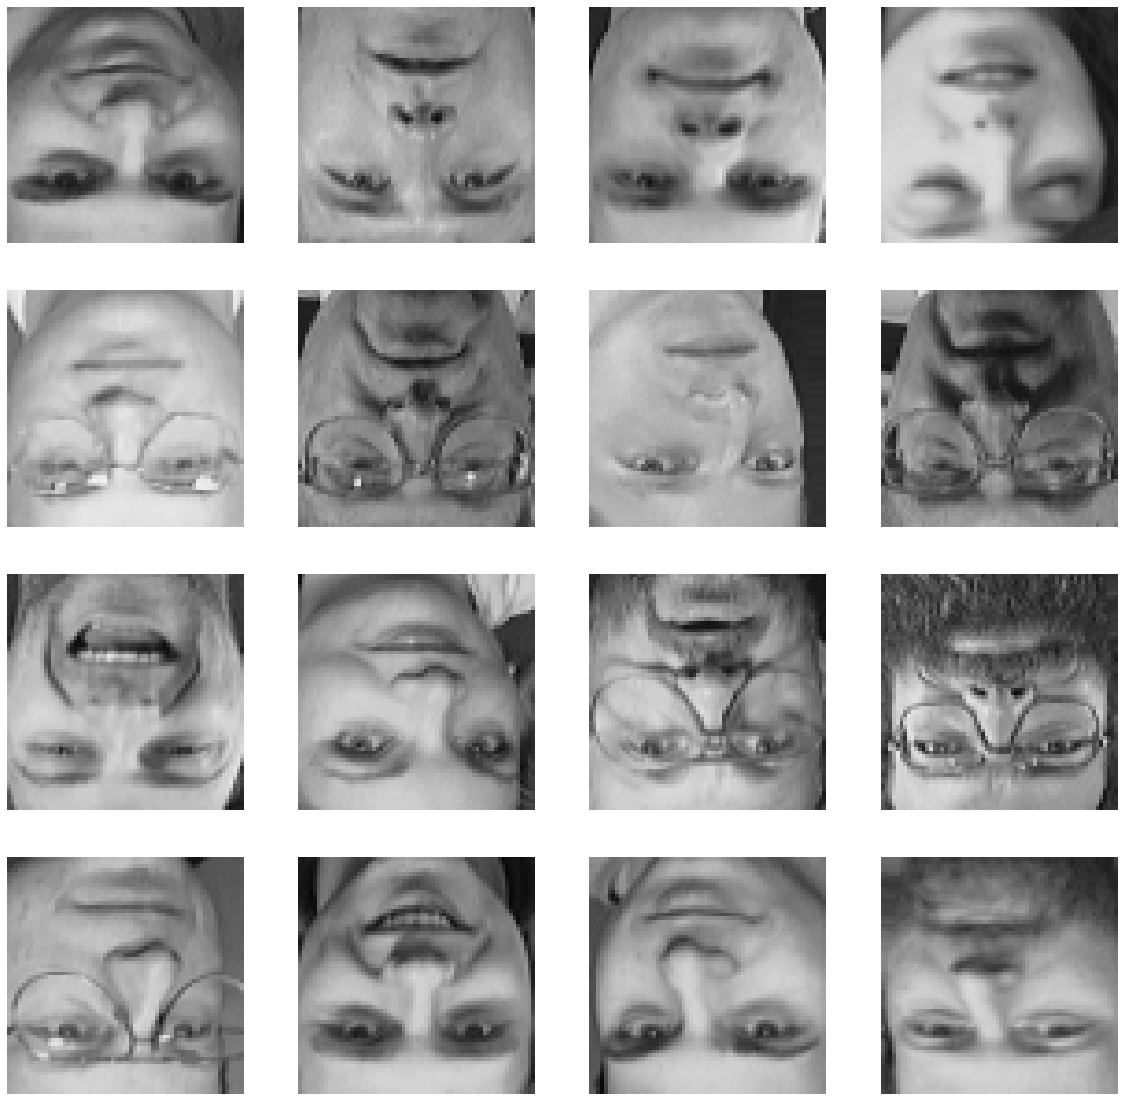

In [17]:
plot_images(fliplr(images[rand3, :, :]))

In [18]:
upsidedown_images = fliplr(images)

#### Tworzenie efektu wirówki

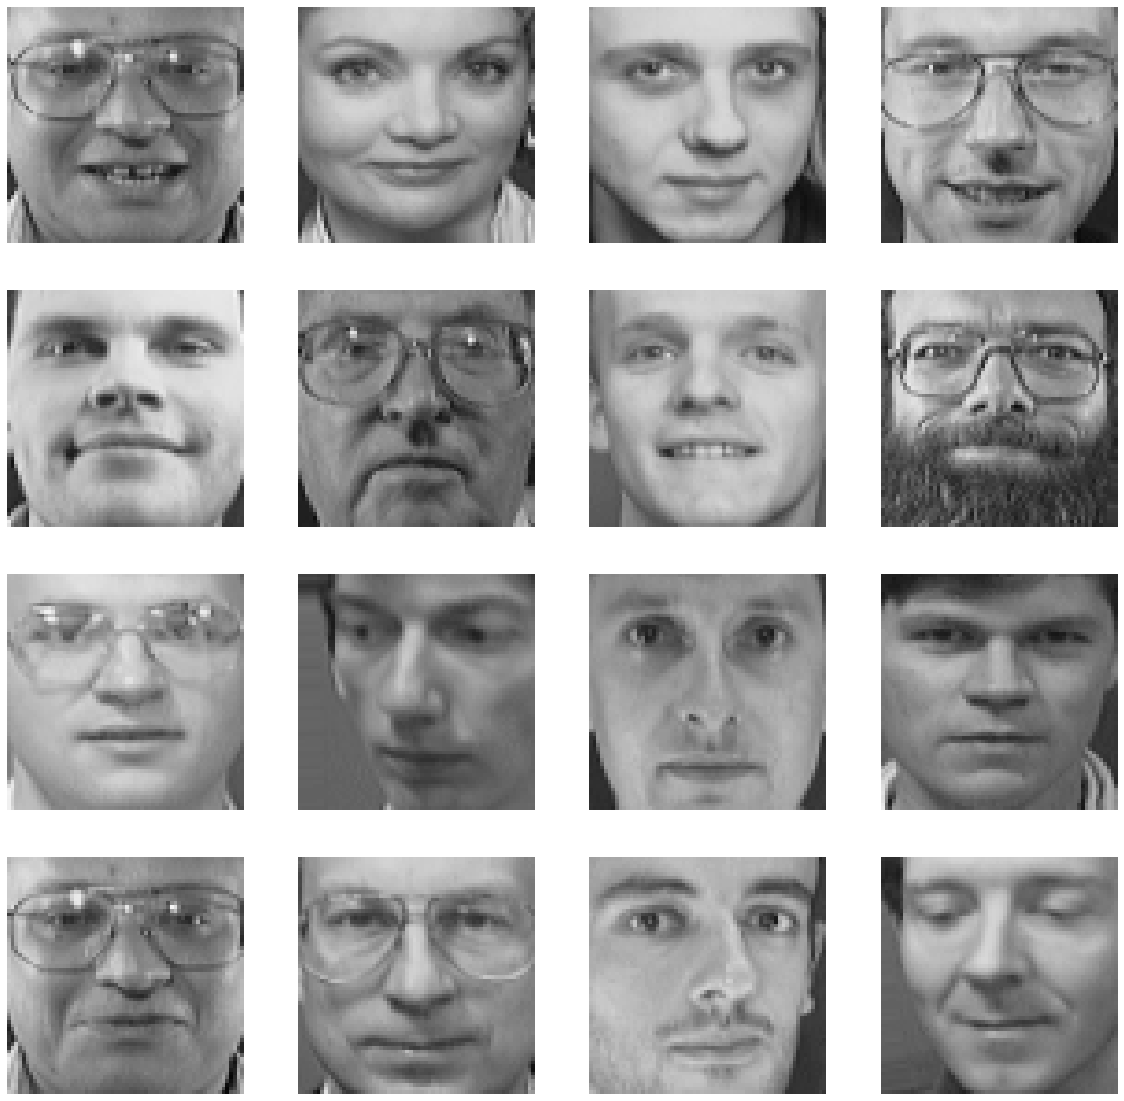

In [19]:
rand4 = np.random.randint(0, 400, 16)
plot_images(images[rand4, :, :])

##### Po transformacji

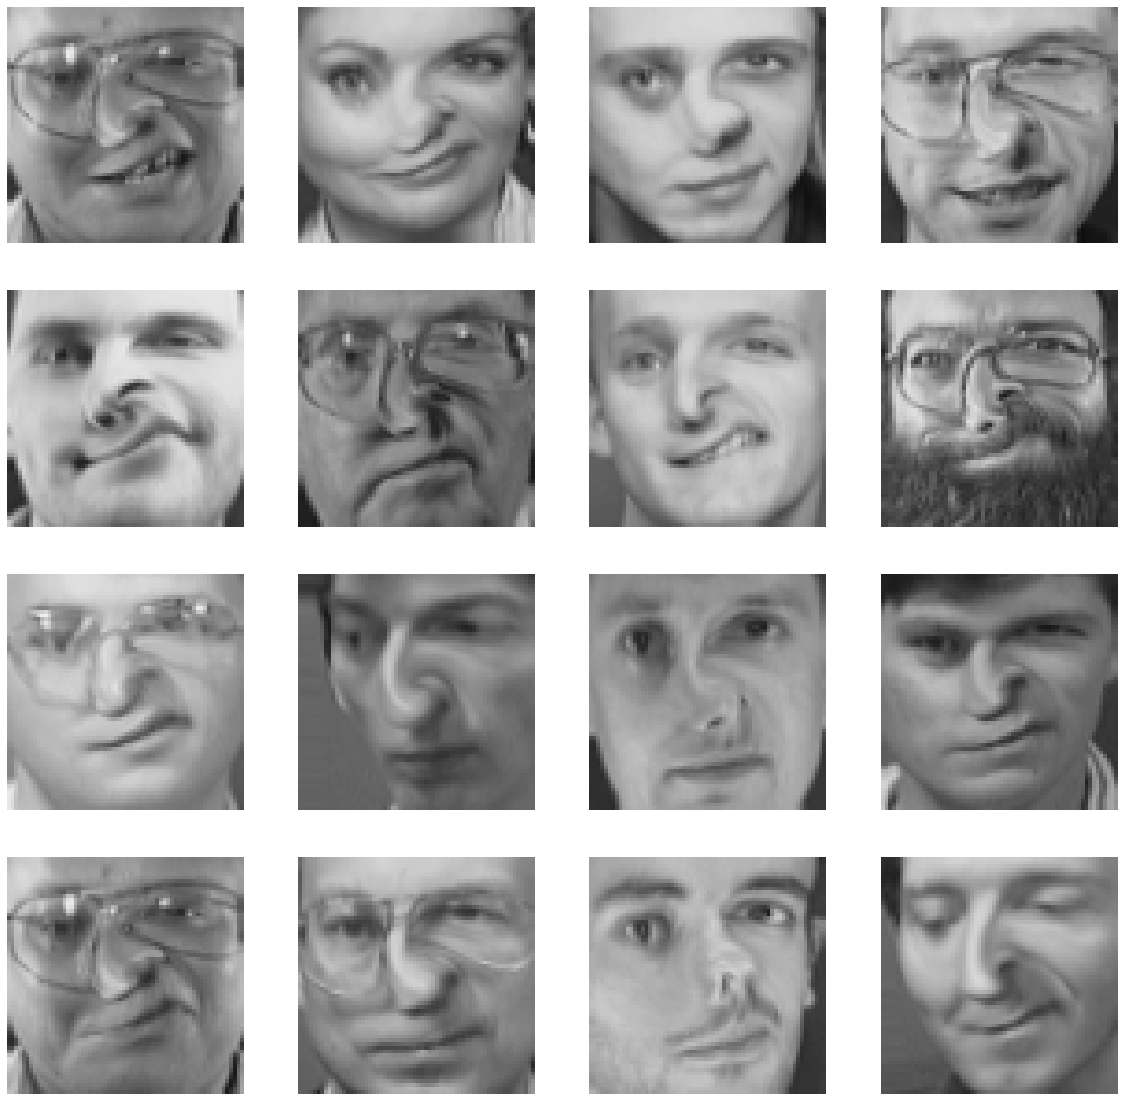

In [20]:
from skimage.transform import swirl
plot_images(images[rand4, :, :], func=partial(swirl, radius=60, strength=2))

In [21]:
swirl_images = swirl(images, radius=60, strength=2)

### Efekty PCA na obrazkach po transformacjach

In [22]:
def rmse_effects(transformed_images, data, name):
    transform = transformed_images.reshape(400, 4096)
    inverse_transform = pca.inverse_transform(pca.transform(transform))
    
    data[name] = mean_squared_error(transform, inv_images, squared=False)

rmse_effects(equalize_images, summary_dict, "histogram equalization")
rmse_effects(rotate_images, summary_dict, "rotate")
rmse_effects(upsidedown_images, summary_dict, "upside-down")
rmse_effects(swirl_images, summary_dict, "swirl")

summary = pd.DataFrame.from_dict(summary_dict, orient='index', columns=["RMSE"])
summary

,RMSE
normal,0.026829
histogram equalization,0.135007
rotate,0.527607
upside-down,0.194938
swirl,0.055183


Widzimy, że obrazy po przekształceniach, uzyskują gorsze wyniki, widać to szczególnie, w przypadku obrotu obrazków o 90 stopni, gdzie uzyskaliliśmy 11-krotnie gorszy wynik. Co ciekawe, w zależności od przekształcenia wyniki się znacznie różnią efekt wirówki uzyskuje ponad dwukrotnie więcej.

### PCA - anomalie
Wiemy z poprzedniego podpunktu, że zdjęcia zmodyfikowane mają gorsze *RMSE*, więc może powinniśmy porównywać *RMSE* zdjęcia z *RMSE* uzyskanym na naszym zbiorze. Widzimy, że po odwrotnej transformacji dostajemy generalne rysy twarzy. Może po odjęciu odwrotnej transorfmacji dostalibyśmy, jakieś szczegóły z danych obrazków.

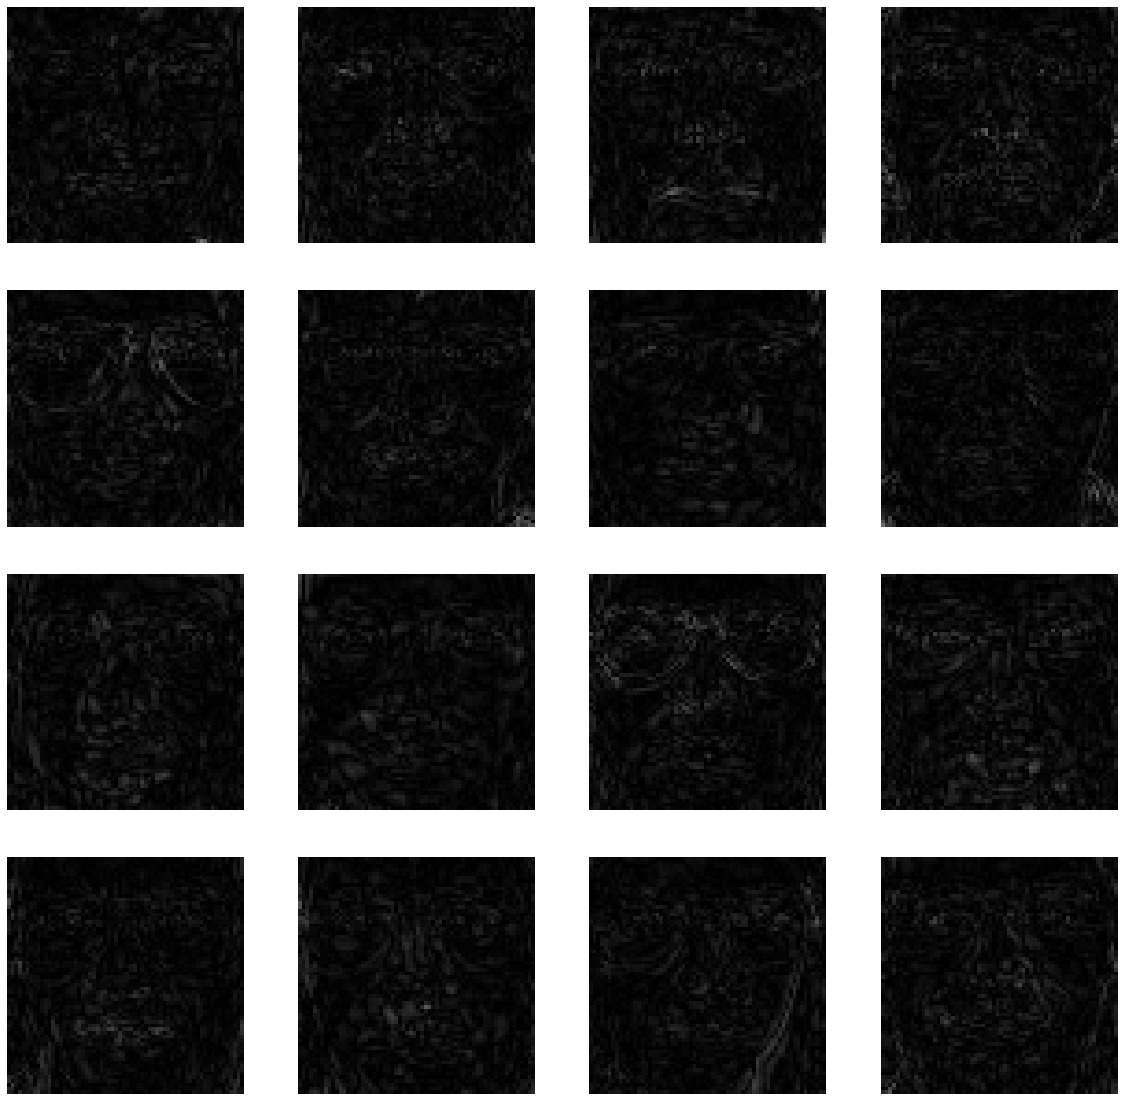

In [23]:
plot_images(2*abs(images.reshape(400, 64, 64)[random, :, :] - inv_images.reshape(400, 64, 64)[random, :, :]))

Chyba moja teza się tak średnio sprawdziła.